Developer: Igor Marques

Dataset: https://www.kaggle.com/vhcg77/telcom-churns-dataset

### Telecom Customer Churn Prediction

Customer churn (also known as customer attrition) is the loss of client or customers over a specific period. Companies such as Netflix, Sky, O2, Insurance Providers, etc., often use customer churn rates as one of their key business metrics as the cost of retaining an existing customer is far less than acquiring a new one.

There are two main types of churn: voluntary and involuntary. Voluntary churn occurs due to a decision by the customer to switch to another provider, whereas involuntary churn occurs due to circumstances beyond the customers/provider control (death, relocation, etc.). In most cases, involuntary churn is excluded for the analytical models. Analysts tend to focus on voluntary reasons because it typically occurs due to factors related to the company (customer relation, billing, satisfaction, etc.).

Predictive analytics use churn prediction models that predict customer churn by assessing their propensity of risk to churn. Since these models generate a small list of customers likely to churn, customer retention market strategies focusing on these customers can be put in place.

Retention Rate is an indication of how good is your product market fit (PMF). If your PMF is not satisfactory, you should see your customers churning very soon. One of the powerful tools to improve Retention Rate (hence the PMF) is Churn Prediction. By using this technique, you can easily find out who is likely to churn in the given period.

## 1. Initialization

In [126]:
# Importing libraries

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb

# Data Processing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score,recall_score
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from catboost import Pool as pool
from catboost import cv
from catboost.utils import get_roc_curve, get_confusion_matrix
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve
from catboost.utils import select_threshold
from xgboost import XGBClassifier
from xgboost import plot_importance


# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# import Hyperopt
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

## 2. Getting the Data

In [2]:
telcom = pd.read_csv('Telco-Customer-Churn.csv')

## 3. Initial Data Manipulation

In [3]:
telcom.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
telcom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Let's confirm whether there are any missing values:

In [5]:
telcom.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Let's create lists for the attributes:

In [6]:
all_att = list(telcom.columns)
num_att = list(telcom._get_numeric_data().columns)
cat_att = list(telcom.select_dtypes(include=['object']).columns)
print('Numerical Attributes:' + '\n {}'.format(num_att))
print('Categorical Attributes:' + '\n {}'.format(cat_att))

Numerical Attributes:
 ['SeniorCitizen', 'tenure', 'MonthlyCharges']
Categorical Attributes:
 ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']


Let's verify the unique values for each categorical attribute:

In [7]:
for col in cat_att:
    print(col + ': ')
    print('Unique values: {}'.format(telcom[col].nunique()))
    print(telcom[col].value_counts())
    print('\n')

customerID: 
Unique values: 7043
7813-TKCVO    1
1619-YWUBB    1
1104-FEJAM    1
6848-HJTXY    1
8652-YHIYU    1
             ..
3635-JBPSG    1
8455-HIRAQ    1
9835-ZIITK    1
5207-PLSTK    1
4021-RQSNY    1
Name: customerID, Length: 7043, dtype: int64


gender: 
Unique values: 2
Male      3555
Female    3488
Name: gender, dtype: int64


Partner: 
Unique values: 2
No     3641
Yes    3402
Name: Partner, dtype: int64


Dependents: 
Unique values: 2
No     4933
Yes    2110
Name: Dependents, dtype: int64


PhoneService: 
Unique values: 2
Yes    6361
No      682
Name: PhoneService, dtype: int64


MultipleLines: 
Unique values: 3
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64


InternetService: 
Unique values: 3
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64


OnlineSecurity: 
Unique values: 3
No                     3498
Yes                    2019
No internet service    1526
Name:

We can notice from the cell above that the columns "TotalCharges" should be a numerical one. Let's investigate why it has been picked up as an object rather than number. Let's first get an overview of the numerical attributes:

In [8]:
telcom.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


Let's verify if there are hidden empty values in the 'TotalCharges' column:

In [9]:
telcom[telcom['TotalCharges']==" "]['TotalCharges'].value_counts()

     11
Name: TotalCharges, dtype: int64

Indeed, there are. There are 11 observations that are empty and were masked with a space in its cell, reason why pandas did not pick it up as nan. Let's replace it by a real **nan**.

In [10]:
telcom['TotalCharges'] = telcom['TotalCharges'].replace(" ", np.nan)

Let's confirm that we have now true null values:

In [11]:
telcom['TotalCharges'].isna().sum()

11

Since we have only 11 empty observations in the 'TotalCharges' column (a very small number of missing data), we will be deleting these rows from our dataset rather them imputing them.

In [12]:
telcom_1 = telcom.copy()
telcom_1 = telcom_1[telcom_1['TotalCharges'].notnull()]

In [13]:
telcom_1 = telcom_1.reset_index()[telcom_1.columns]
telcom_1

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7028,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7029,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7030,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


Now let's convert 'TotalCharges' to float:

In [14]:
telcom_1['TotalCharges'] = telcom_1['TotalCharges'].astype(float)
telcom_1.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


The column 'SeniorCitizen' seems to be an object masked as a numerical variable. Let's deal with that:

In [15]:
telcom_1['SeniorCitizen'] = telcom['SeniorCitizen'].replace({1:"Yes", 0:"No"})
telcom_1['SeniorCitizen']

0        No
1        No
2        No
3        No
4        No
       ... 
7027     No
7028     No
7029    Yes
7030     No
7031    Yes
Name: SeniorCitizen, Length: 7032, dtype: object

Let's update our attributes lists:

In [16]:
all_att = list(telcom_1.columns)
num_att = list(telcom_1._get_numeric_data().columns)
cat_att = list(telcom_1.select_dtypes(include=['object']).columns)
print('Numerical Attributes:' + '\n {}'.format(num_att))
print('Categorical Attributes:' + '\n {}'.format(cat_att))

Numerical Attributes:
 ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical Attributes:
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


In [17]:
telcom_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   object 
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


For the columns 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies' let's replace the 'No internet service' to 'No' as they mean, in practice, the same thing:

In [18]:
temp_list = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in temp_list:
    telcom_1[col] = telcom_1[col].replace({"No internet service":"No"})

Let's verify it the values are correct:

In [19]:
for col in cat_att:
    print(col + ":")
    print(telcom_1[col].value_counts())
    print('\n')

customerID:
7813-TKCVO    1
1619-YWUBB    1
2379-GYFLQ    1
1104-FEJAM    1
6848-HJTXY    1
             ..
9835-ZIITK    1
5207-PLSTK    1
7156-MHUGY    1
1855-CFULU    1
4021-RQSNY    1
Name: customerID, Length: 7032, dtype: int64


gender:
Male      3549
Female    3483
Name: gender, dtype: int64


SeniorCitizen:
No     5892
Yes    1140
Name: SeniorCitizen, dtype: int64


Partner:
No     3639
Yes    3393
Name: Partner, dtype: int64


Dependents:
No     4933
Yes    2099
Name: Dependents, dtype: int64


PhoneService:
Yes    6352
No      680
Name: PhoneService, dtype: int64


MultipleLines:
No                  3385
Yes                 2967
No phone service     680
Name: MultipleLines, dtype: int64


InternetService:
Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64


OnlineSecurity:
No     5017
Yes    2015
Name: OnlineSecurity, dtype: int64


OnlineBackup:
No     4607
Yes    2425
Name: OnlineBackup, dtype: int64


DeviceProtection:
No     46

The 'tenure' column could be better represented in tenure bands. So let's create these bands and create a new categorical attribute:

In [20]:
def tenure_bands(df):
    if df['tenure'] <= 12:
        return "Tenure_0-12"
    elif (df['tenure'] > 12) & (df['tenure'] <= 24):
        return "Tenure_13-24"
    elif (df['tenure'] > 24) & (df['tenure'] <= 48):
        return "Tenure_25-48"
    elif (df['tenure'] > 48) & (df['tenure'] <= 60):
        return "Tenure_49-60"
    elif df['tenure'] > 60:
        return "Tenure_gt_60"

In [21]:
telcom_2 = telcom_1.copy()
telcom_2['tenure_group'] = telcom_2.apply(lambda telcom_2:tenure_bands(telcom_2), axis=1)
telcom_2['tenure_group']

0        Tenure_0-12
1       Tenure_25-48
2        Tenure_0-12
3       Tenure_25-48
4        Tenure_0-12
            ...     
7027    Tenure_13-24
7028    Tenure_gt_60
7029     Tenure_0-12
7030     Tenure_0-12
7031    Tenure_gt_60
Name: tenure_group, Length: 7032, dtype: object

In [22]:
telcom_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   object 
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


Let's update our list once again. We will also remove 'customerID' and 'Churn' from our lists.

In [23]:
all_att = list(telcom_2.columns)
num_att = list(telcom_2._get_numeric_data().columns)
cat_att = list(telcom_2.select_dtypes(include=['object']).columns)

id_col = ['customerID']
target = ['Churn']
cat_att = [x for x in cat_att if x not in id_col + target]

print('Numerical Attributes:' + '\n {}'.format(num_att))
print('Categorical Attributes:' + '\n {}'.format(cat_att))

Numerical Attributes:
 ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical Attributes:
 ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_group']


## 4. Exploratory Data Analysis

### Customer Churn Overview

In [24]:
labels = telcom_2['Churn'].value_counts().keys().tolist()
values = telcom_2['Churn'].value_counts().values.tolist()

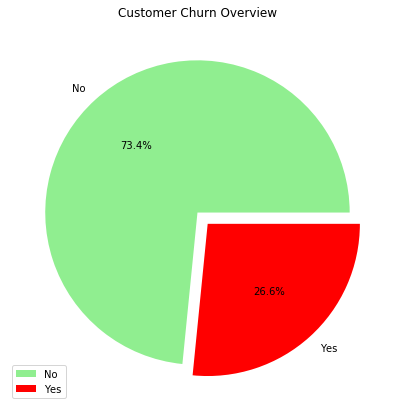

In [25]:
fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(values, 
        labels=labels, 
        explode=(0,0.1), 
        autopct='%1.1f%%',
        colors=['lightgreen', 'red'])
plt.legend()
plt.title('Customer Churn Overview')
plt.show()

The actual Churn Rate in this dataset is 26.6% which reflects as 73.4% for model performance. In other words, this should be the baseline value for performance.

From the graph above, we can clearly see that our dataset is imbalanced as there are a disproportionate rate of observations between the 'Yes' and 'No' classes. We will deal with this issue in the data preparation step.

### Variables Distribution by Churn Rate

**Churn Distribution by Gender**

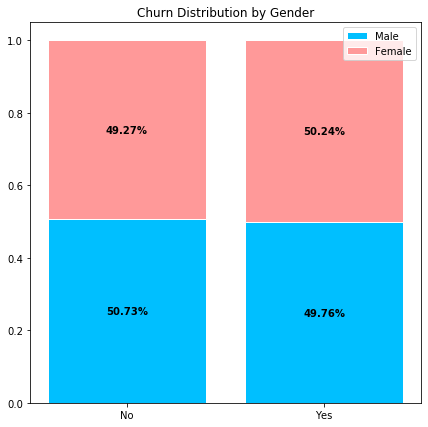

In [26]:
no_churn = ((telcom_2[telcom_2['Churn']=='No']['gender'].value_counts())
            /(telcom_2[telcom_2['Churn']=='No']['gender'].value_counts().sum()))
yes_churn = ((telcom_2[telcom_2['Churn']=='Yes']['gender'].value_counts())
            /(telcom_2[telcom_2['Churn']=='Yes']['gender'].value_counts().sum()))

# Getting values from the group and categories
x_labels = telcom_2['Churn'].value_counts().keys().tolist()
male = [no_churn['Male'], yes_churn['Male']]
female = [no_churn['Female'], yes_churn['Female']]

# Plotting bars
barWidth = 0.8
plt.figure(figsize=(7,7))
ax1 = plt.bar(x_labels, male, color='#00BFFF', label='Male', 
              edgecolor='white', width=barWidth)
ax2 = plt.bar(x_labels, female, bottom=male, color='#FF9999', label='Female', 
              edgecolor='white', width=barWidth)
plt.legend()
plt.title('Churn Distribution by Gender')

for r1, r2 in zip(ax1, ax2):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., '{:.2%}'.format(h1),
            ha='center', va='center', color='black', fontweight='bold')
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., '{:.2%}'.format(h2),
            ha='center', va='center', color='black', fontweight='bold')
    
plt.show()

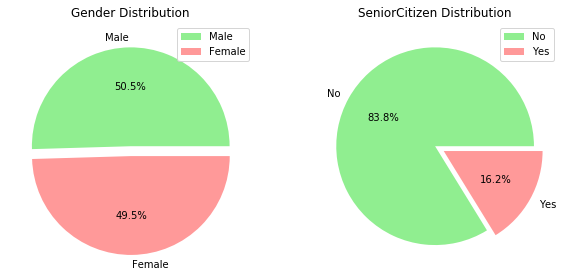

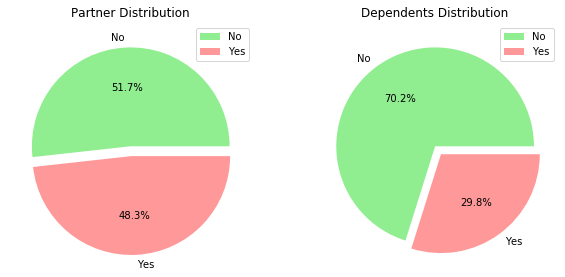

In [27]:
labels = telcom_2['gender'].value_counts().keys().tolist()
values = telcom_2['gender'].value_counts().values.tolist()

plt.subplots(figsize=(10,10))

plt.subplot(221)
plt.pie(values,
       labels=labels,
       explode=(0,0.1), 
       autopct='%1.1f%%',
       colors=['lightgreen', '#FF9999'])

plt.legend()
plt.title('Gender Distribution')

labels = telcom_2['SeniorCitizen'].value_counts().keys().tolist()
values = telcom_2['SeniorCitizen'].value_counts().values.tolist()

plt.subplot(222)
plt.pie(values,
       labels=labels,
       explode=(0,0.1), 
       autopct='%1.1f%%',
       colors=['lightgreen', '#FF9999'])

plt.legend()
plt.title('SeniorCitizen Distribution')
plt.show()

labels = telcom_2['Partner'].value_counts().keys().tolist()
values = telcom_2['Partner'].value_counts().values.tolist()

plt.subplots(figsize=(10,10))
plt.subplot(223)
plt.pie(values,
       labels=labels,
       explode=(0,0.1), 
       autopct='%1.1f%%',
       colors=['lightgreen', '#FF9999'])

plt.legend()
plt.title('Partner Distribution')


labels = telcom_2['Dependents'].value_counts().keys().tolist()
values = telcom_2['Dependents'].value_counts().values.tolist()

plt.subplot(224)
plt.pie(values,
       labels=labels,
       explode=(0,0.1), 
       autopct='%1.1f%%',
       colors=['lightgreen', '#FF9999'])

plt.legend()
plt.title('Dependents Distribution')
plt.show()

Female customer are more likely to churn, however, the difference is mininmal. Not much can be inferred form Gender.

**Function for Variables with 'Yes' or 'No' values:**

In [28]:
def y_n_churn_var_distribution(col_name):
    
    no_churn = ((telcom_2[telcom_2['Churn']=='No'][col_name].value_counts())
                /(telcom_2[telcom_2['Churn']=='No'][col_name].value_counts().sum()))
    yes_churn = ((telcom_2[telcom_2['Churn']=='Yes'][col_name].value_counts())
                /(telcom_2[telcom_2['Churn']=='Yes'][col_name].value_counts().sum()))

    # Getting values from the group and categories
    x_labels = telcom_2['Churn'].value_counts().keys().tolist()
    n_var = [no_churn['No'], yes_churn['No']]
    y_var = [no_churn['Yes'], yes_churn['Yes']]

    # Plotting bars
    barWidth = 0.8
    plt.figure(figsize=(7,7))
    ax1 = plt.bar(x_labels, n_var, color='#00BFFF', 
                  label=('No ' + col_name), edgecolor='white', width=barWidth)
    ax2 = plt.bar(x_labels, y_var, bottom=n_var, color='lightgreen',
                  label=('Yes ' + col_name), edgecolor='white', width=barWidth)
    plt.legend()
    plt.title('Churn Distribution by ' + col_name)

    for r1, r2 in zip(ax1, ax2):
        h1 = r1.get_height()
        h2 = r2.get_height()
        plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., '{:.2%}'.format(h1),
                ha='center', va='center', color='black', fontweight='bold')
        plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., '{:.2%}'.format(h2),
                ha='center', va='center', color='black', fontweight='bold')

    plt.show()


**Churn Distribution by Senior Citizen**

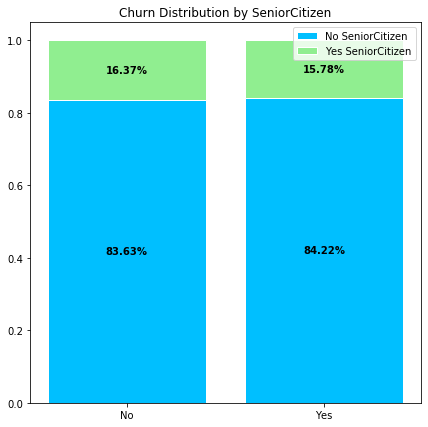

In [29]:
y_n_churn_var_distribution('SeniorCitizen')

**Churn Distribution by Partner**

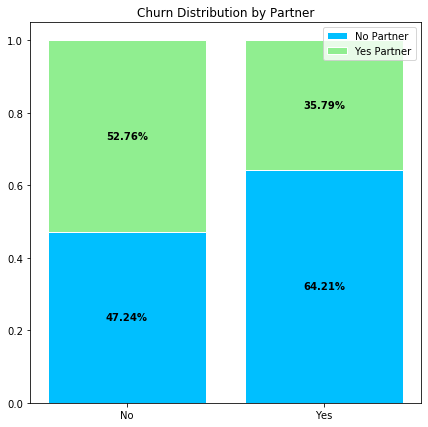

In [30]:
y_n_churn_var_distribution('Partner')

From the graph above, we can say that customers that have no partner are more likely to churn.

**Churn Distribution by Dependents**

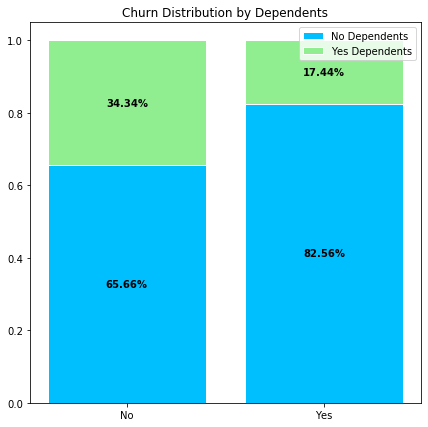

In [31]:
y_n_churn_var_distribution('Dependents')

**Churn Distribution by Phone Service**

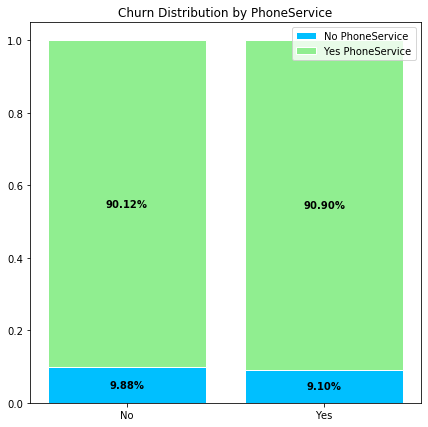

In [32]:
y_n_churn_var_distribution('PhoneService')

**Churn Distribution by Online Security**

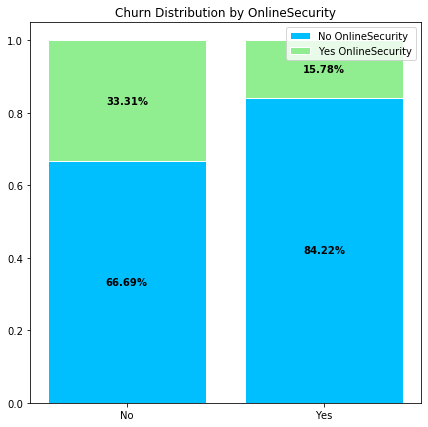

In [33]:
y_n_churn_var_distribution('OnlineSecurity')

**Churn Distribution by Online Backup**

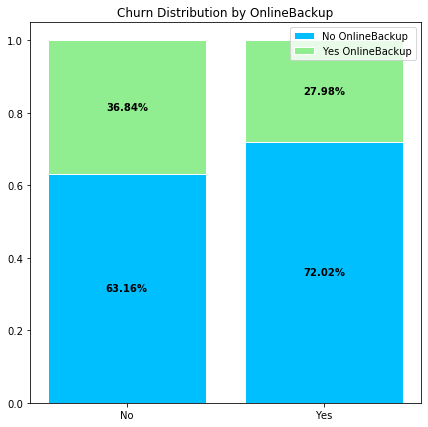

In [34]:
y_n_churn_var_distribution('OnlineBackup')

**Churn Distribution by Device Protection**

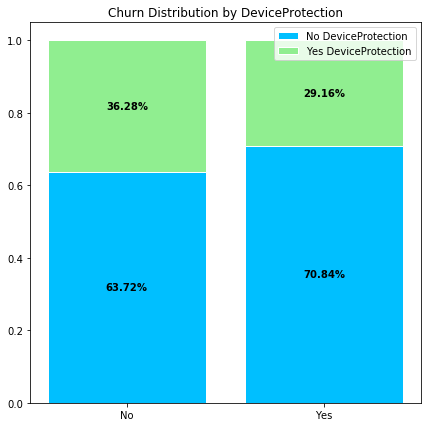

In [35]:
y_n_churn_var_distribution('DeviceProtection')

**Churn Distribution by Tech Support**

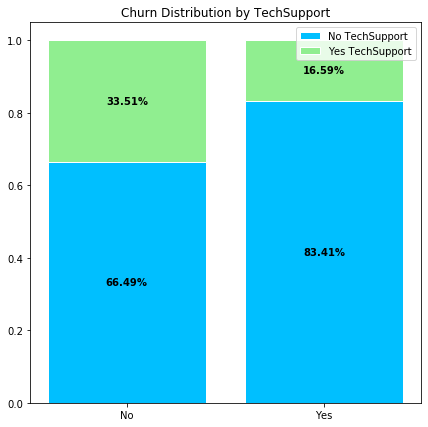

In [36]:
y_n_churn_var_distribution('TechSupport')

**Churn Distribution by Streaming TV**

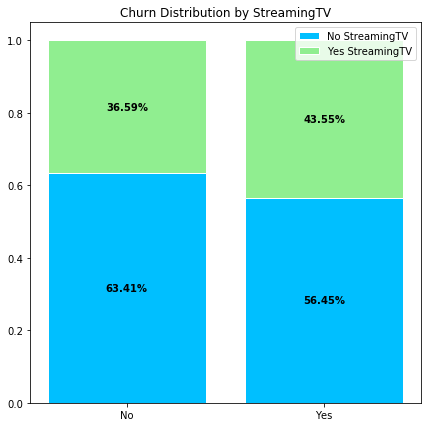

In [37]:
y_n_churn_var_distribution('StreamingTV')

**Churn Distribution by Streaming Movies**

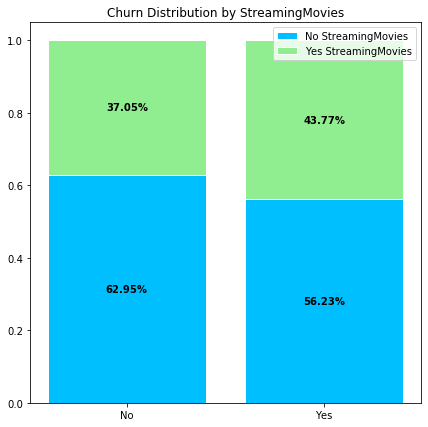

In [38]:
y_n_churn_var_distribution('StreamingMovies')

**Churn Distribution by Paperless Billing**

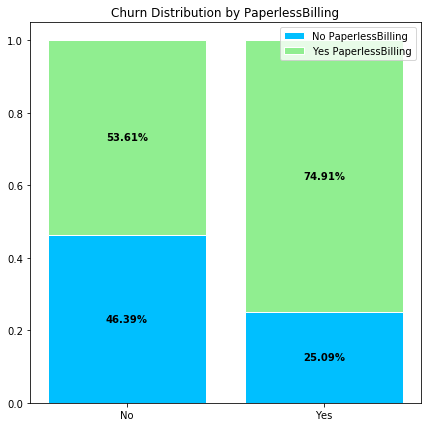

In [39]:
y_n_churn_var_distribution('PaperlessBilling')

**Variables with multivariate classes**

**Churn Distribution by Tenure Group**

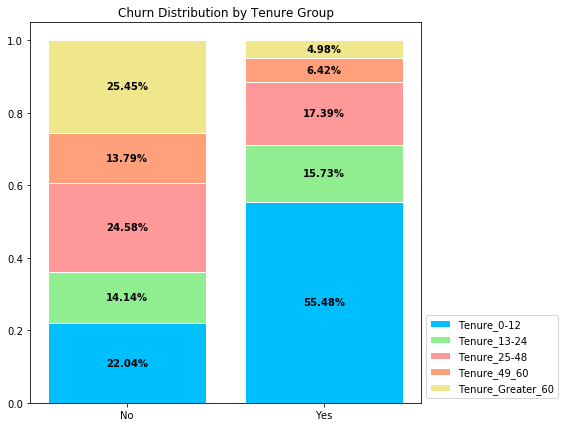

In [40]:
no_churn = ((telcom_2[telcom_2['Churn']=='No']['tenure_group'].value_counts())
            /(telcom_2[telcom_2['Churn']=='No']['tenure_group'].value_counts().sum()))
yes_churn = ((telcom_2[telcom_2['Churn']=='Yes']['tenure_group'].value_counts())
            /(telcom_2[telcom_2['Churn']=='Yes']['tenure_group'].value_counts().sum()))

# Getting values from the group and categories
x_labels = telcom_2['Churn'].value_counts().keys().tolist()
t_0_12 = [no_churn['Tenure_0-12'], yes_churn['Tenure_0-12']]
t_13_24 = [no_churn['Tenure_13-24'], yes_churn['Tenure_13-24']]
t_25_48 = [no_churn['Tenure_25-48'], yes_churn['Tenure_25-48']]
t_49_60 = [no_churn['Tenure_49-60'], yes_churn['Tenure_49-60']]
t_gt_60 = [no_churn['Tenure_gt_60'], yes_churn['Tenure_gt_60']]


# Plotting bars
barWidth = 0.8
plt.figure(figsize=(7,7))
ax1 = plt.bar(x_labels, t_0_12, color='#00BFFF', 
              label=('Tenure_0-12'), edgecolor='white', width=barWidth)
ax2 = plt.bar(x_labels, t_13_24, bottom=t_0_12, color='lightgreen', 
              label=('Tenure_13-24'), edgecolor='white', width=barWidth)
ax3 = plt.bar(x_labels, t_25_48, bottom=np.array(t_0_12) + np.array(t_13_24), color='#FF9999', 
              label=('Tenure_25-48'), edgecolor='white', width=barWidth)
ax4 = plt.bar(x_labels, t_49_60, bottom=np.array(t_0_12) + np.array(t_13_24) + np.array(t_25_48), color='#FFA07A', 
              label=('Tenure_49_60'), edgecolor='white', width=barWidth)
ax5 = plt.bar(x_labels, t_gt_60, bottom=np.array(t_0_12) + np.array(t_13_24) + np.array(t_25_48) + np.array(t_49_60), color='#F0E68C', 
              label=('Tenure_Greater_60'), edgecolor='white', width=barWidth)

plt.legend(loc='lower left', bbox_to_anchor=(1,0))
plt.title('Churn Distribution by Tenure Group')

for r1, r2, r3, r4, r5 in zip(ax1, ax2, ax3, ax4, ax5):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    h4 = r4.get_height()
    h5 = r5.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., '{:.2%}'.format(h1),
            ha='center', va='center', color='black', fontweight='bold')
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., '{:.2%}'.format(h2),
            ha='center', va='center', color='black', fontweight='bold')
    plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 + h3 / 2., '{:.2%}'.format(h3),
            ha='center', va='center', color='black', fontweight='bold')
    plt.text(r4.get_x() + r4.get_width() / 2., h1 + h2 + h3 + h4 / 2., '{:.2%}'.format(h4),
            ha='center', va='center', color='black', fontweight='bold')
    plt.text(r5.get_x() + r5.get_width() / 2., h1 + h2 + h3 + h4 + h5 / 2., '{:.2%}'.format(h5),
            ha='center', va='center', color='black', fontweight='bold')



plt.show()

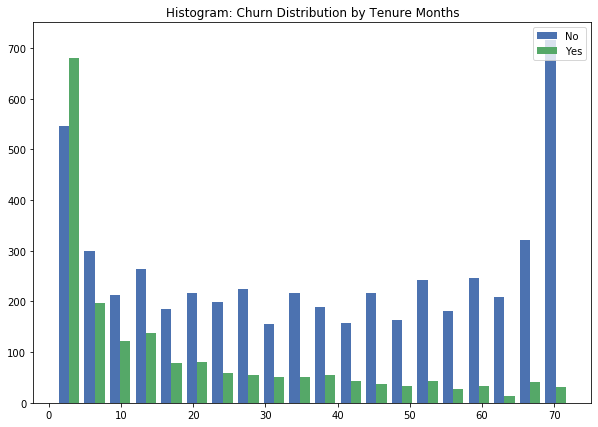

In [41]:
plt.figure(figsize=(10,7))
plt.style.use('seaborn-deep')
plt.hist([telcom_2[telcom_2['Churn']=='No']['tenure'], telcom_2[telcom_2['Churn']=='Yes']['tenure']],
         bins=20,
         label=['No', 'Yes'])
plt.legend(loc='upper right')
plt.title('Histogram: Churn Distribution by Tenure Months')
plt.show()

We can see from the graph below that the higher the tenure, the lower the Churn Rate.

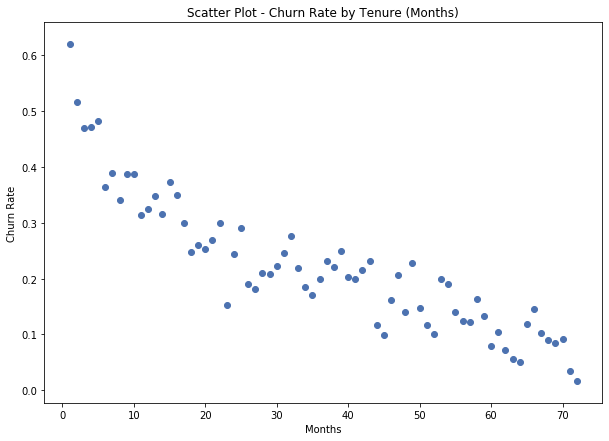

In [42]:
telcom_2_tenure_plot = telcom_2.copy()
telcom_2_tenure_plot.loc[telcom_2_tenure_plot['Churn']=='No', 'Churn'] = 0
telcom_2_tenure_plot.loc[telcom_2_tenure_plot['Churn']=='Yes', 'Churn'] = 1
telcom_2_tenure_plot['Churn'] = telcom_2_tenure_plot['Churn'].astype(int)

scatter_plot = telcom_2_tenure_plot.groupby('tenure').mean().Churn.reset_index()


plt.figure(figsize=(10,7))
plt.scatter(scatter_plot['tenure'], scatter_plot['Churn'])
plt.title('Scatter Plot - Churn Rate by Tenure (Months)')
plt.xlabel('Months')
plt.ylabel('Churn Rate')
plt.show()

Another clear trend, the higher the tenure the lower the Churn likelihood.

**Churn Distribution by Payment Method**

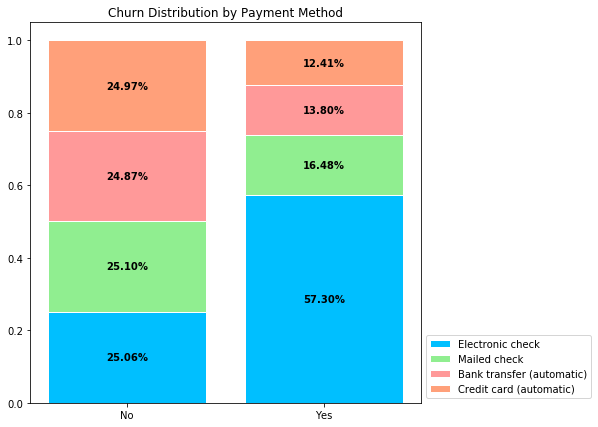

In [43]:
no_churn = ((telcom_2[telcom_2['Churn']=='No']['PaymentMethod'].value_counts())
            /(telcom_2[telcom_2['Churn']=='No']['PaymentMethod'].value_counts().sum()))
yes_churn = ((telcom_2[telcom_2['Churn']=='Yes']['PaymentMethod'].value_counts())
            /(telcom_2[telcom_2['Churn']=='Yes']['PaymentMethod'].value_counts().sum()))

# Getting values from the group and categories
x_labels = telcom_2['Churn'].value_counts().keys().tolist()
elec_check = [no_churn['Electronic check'], yes_churn['Electronic check']]
mail_check = [no_churn['Mailed check'], yes_churn['Mailed check']]
bank_tr = [no_churn['Bank transfer (automatic)'], yes_churn['Bank transfer (automatic)']]
credit_c = [no_churn['Credit card (automatic)'], yes_churn['Credit card (automatic)']]


# Plotting bars
barWidth = 0.8
plt.figure(figsize=(7,7))
ax1 = plt.bar(x_labels, elec_check, color='#00BFFF', 
              label=('Electronic check'), edgecolor='white', width=barWidth)
ax2 = plt.bar(x_labels, mail_check, bottom=elec_check, color='lightgreen', 
              label=('Mailed check'), edgecolor='white', width=barWidth)
ax3 = plt.bar(x_labels, bank_tr, bottom=np.array(elec_check) + np.array(mail_check), color='#FF9999', 
              label=('Bank transfer (automatic)'), edgecolor='white', width=barWidth)
ax4 = plt.bar(x_labels, credit_c, bottom=np.array(elec_check) + np.array(mail_check) + np.array(bank_tr), color='#FFA07A', 
              label=('Credit card (automatic)'), edgecolor='white', width=barWidth)

plt.legend(loc='lower left', bbox_to_anchor=(1,0))
plt.title('Churn Distribution by Payment Method')

for r1, r2, r3, r4 in zip(ax1, ax2, ax3, ax4):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    h4 = r4.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., '{:.2%}'.format(h1),
            ha='center', va='center', color='black', fontweight='bold')
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., '{:.2%}'.format(h2),
            ha='center', va='center', color='black', fontweight='bold')
    plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 + h3 / 2., '{:.2%}'.format(h3),
            ha='center', va='center', color='black', fontweight='bold')
    plt.text(r4.get_x() + r4.get_width() / 2., h1 + h2 + h3 + h4 / 2., '{:.2%}'.format(h4),
            ha='center', va='center', color='black', fontweight='bold')
plt.show()


We can see here that the categories with the lower churn rates come from the automatic payments type. Thus, customers using conventional payment methods (such as mailed or electronic check), are more likely to churn.

**Churn Distribution by Internet Service**

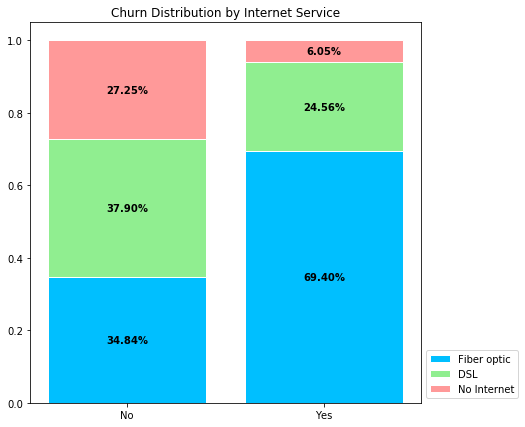

In [44]:
no_churn = ((telcom_2[telcom_2['Churn']=='No']['InternetService'].value_counts())
            /(telcom_2[telcom_2['Churn']=='No']['InternetService'].value_counts().sum()))
yes_churn = ((telcom_2[telcom_2['Churn']=='Yes']['InternetService'].value_counts())
            /(telcom_2[telcom_2['Churn']=='Yes']['InternetService'].value_counts().sum()))

# Getting values from the group and categories
x_labels = telcom_2['Churn'].value_counts().keys().tolist()
fiber_op = [no_churn['Fiber optic'], yes_churn['Fiber optic']]
dsl = [no_churn['DSL'], yes_churn['DSL']]
no_int = [no_churn['No'], yes_churn['No']]


# Plotting bars
barWidth = 0.8
plt.figure(figsize=(7,7))
ax1 = plt.bar(x_labels, fiber_op, color='#00BFFF', 
              label=('Fiber optic'), edgecolor='white', width=barWidth)
ax2 = plt.bar(x_labels, dsl, bottom=fiber_op, color='lightgreen', 
              label=('DSL'), edgecolor='white', width=barWidth)
ax3 = plt.bar(x_labels, no_int, bottom=np.array(fiber_op) + np.array(dsl), color='#FF9999', 
              label=('No Internet'), edgecolor='white', width=barWidth)

plt.legend(loc='lower left', bbox_to_anchor=(1,0))
plt.title('Churn Distribution by Internet Service')

for r1, r2, r3, r4 in zip(ax1, ax2, ax3, ax4):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., '{:.2%}'.format(h1),
            ha='center', va='center', color='black', fontweight='bold')
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., '{:.2%}'.format(h2),
            ha='center', va='center', color='black', fontweight='bold')
    plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 + h3 / 2., '{:.2%}'.format(h3),
            ha='center', va='center', color='black', fontweight='bold')

plt.show()

We can notice from the data that customers with Fiber optic as Internet Service are more likely to churn. Usually, one would expect that customers using Fiber optic services would churn less due to the fact they have better services. But that could change given other factors such as high prices, competition, customer service, etc.

**Churn Distribution by Contract Type**

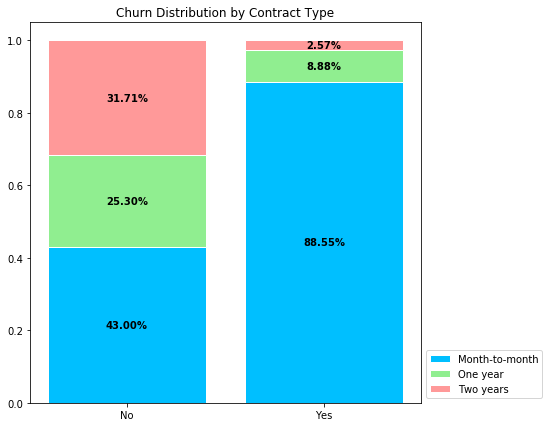

In [45]:
no_churn = ((telcom_2[telcom_2['Churn']=='No']['Contract'].value_counts())
            /(telcom_2[telcom_2['Churn']=='No']['Contract'].value_counts().sum()))
yes_churn = ((telcom_2[telcom_2['Churn']=='Yes']['Contract'].value_counts())
            /(telcom_2[telcom_2['Churn']=='Yes']['Contract'].value_counts().sum()))

# Getting values from the group and categories
x_labels = telcom_2['Churn'].value_counts().keys().tolist()
m_t_m = [no_churn['Month-to-month'], yes_churn['Month-to-month']]
one_y = [no_churn['One year'], yes_churn['One year']]
two_y = [no_churn['Two year'], yes_churn['Two year']]


# Plotting bars
barWidth = 0.8
plt.figure(figsize=(7,7))
ax1 = plt.bar(x_labels, m_t_m, color='#00BFFF', 
              label=('Month-to-month'), edgecolor='white', width=barWidth)
ax2 = plt.bar(x_labels, one_y, bottom=m_t_m, color='lightgreen', 
              label=('One year'), edgecolor='white', width=barWidth)
ax3 = plt.bar(x_labels, two_y, bottom=np.array(m_t_m) + np.array(one_y), color='#FF9999', 
              label=('Two years'), edgecolor='white', width=barWidth)

plt.legend(loc='lower left', bbox_to_anchor=(1,0))
plt.title('Churn Distribution by Contract Type')

for r1, r2, r3 in zip(ax1, ax2, ax3):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., '{:.2%}'.format(h1),
            ha='center', va='center', color='black', fontweight='bold')
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., '{:.2%}'.format(h2),
            ha='center', va='center', color='black', fontweight='bold')
    plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 + h3 / 2., '{:.2%}'.format(h3),
            ha='center', va='center', color='black', fontweight='bold')

plt.show()

Here we have a very clear trend: the shorther the contract the higher the churn rate, which makes sense.

**Average Monthly and Total Charges by Tenure Groups**

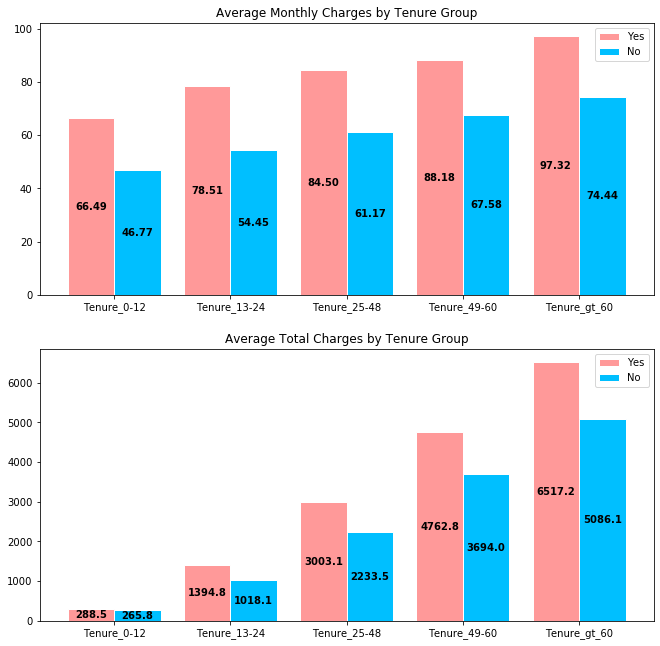

In [46]:
groups = telcom_2['tenure_group'].value_counts().keys().tolist()
groups.sort()
mean_yes_m_charges = {}
mean_no_m_charges = {}
mean_yes_t_charges = {}
mean_no_t_charges = {}
for group in groups:  
    mean_yes_m_charges[group] = np.mean(telcom_2[(telcom_2['tenure_group']==group) & (telcom_2['Churn']=='Yes')]['MonthlyCharges'])
    mean_no_m_charges[group] = np.mean(telcom_2[(telcom_2['tenure_group']==group) & (telcom_2['Churn']=='No')]['MonthlyCharges'])
    mean_yes_t_charges[group] = np.mean(telcom_2[(telcom_2['tenure_group']==group) & (telcom_2['Churn']=='Yes')]['TotalCharges'])
    mean_no_t_charges[group] = np.mean(telcom_2[(telcom_2['tenure_group']==group) & (telcom_2['Churn']=='No')]['TotalCharges'])

plt.subplots(figsize=(11,11))
plt.subplot(211)
barWidth = 0.4
ax1 = plt.bar(np.arange(len(groups)), 
              list(mean_yes_m_charges.values()), 
              barWidth, 
              color='#FF9999', 
              edgecolor='white')
ax2 = plt.bar(np.arange(len(groups))+barWidth, 
              list(mean_no_m_charges.values()), 
              barWidth, 
              color='#00BFFF', 
              edgecolor='white')
plt.xticks(np.arange(len(groups))+barWidth/2, groups)
plt.legend(['Yes', 'No'])
plt.title('Average Monthly Charges by Tenure Group')

for r1, r2 in zip(ax1, ax2):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., '{:.2f}'.format(h1),
            ha='center', va='center', color='black', fontweight='bold')
    plt.text(r2.get_x() + r2.get_width() / 2., h2 / 2., '{:.2f}'.format(h2),
            ha='center', va='center', color='black', fontweight='bold')

plt.subplot(212)
ax1 = plt.bar(np.arange(len(groups)), 
              list(mean_yes_t_charges.values()), 
              barWidth, 
              color='#FF9999', 
              edgecolor='white')
ax2 = plt.bar(np.arange(len(groups))+barWidth, 
              list(mean_no_t_charges.values()), 
              barWidth,
              color='#00BFFF',
              edgecolor='white')
plt.xticks(np.arange(len(groups))+barWidth/2, groups)
plt.legend(['Yes', 'No'])
plt.title('Average Total Charges by Tenure Group')

for r1, r2 in zip(ax1, ax2):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., '{:.1f}'.format(h1),
            ha='center', va='center', color='black', fontweight='bold')
    plt.text(r2.get_x() + r2.get_width() / 2., h2 / 2., '{:.1f}'.format(h2),
            ha='center', va='center', color='black', fontweight='bold')

plt.show()

**Correlation Matrix**

Let's first enconde our target variable 'Churn' using the Label Enconder:

In [47]:
le = LabelEncoder()
telcom_2['Churn'] = le.fit_transform(telcom_2['Churn'])

Let's now get the dummies for the categorical variables, excluding the 'customerID' (which is irrelevant for our analysis):

In [48]:
telcom_2_dummies = pd.get_dummies(telcom_2[num_att + cat_att + target])
telcom_2_dummies.head()

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,...,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_Tenure_0-12,tenure_group_Tenure_13-24,tenure_group_Tenure_25-48,tenure_group_Tenure_49-60,tenure_group_Tenure_gt_60
0,1,29.85,29.85,0,1,0,1,0,0,1,...,1,0,0,1,0,1,0,0,0,0
1,34,56.95,1889.50,0,0,1,1,0,1,0,...,0,0,0,0,1,0,0,1,0,0
2,2,53.85,108.15,1,0,1,1,0,1,0,...,1,0,0,0,1,1,0,0,0,0
3,45,42.30,1840.75,0,0,1,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0
4,2,70.70,151.65,1,1,0,1,0,1,0,...,1,0,0,1,0,1,0,0,0,0


Now, let's plot our correlation matrix:

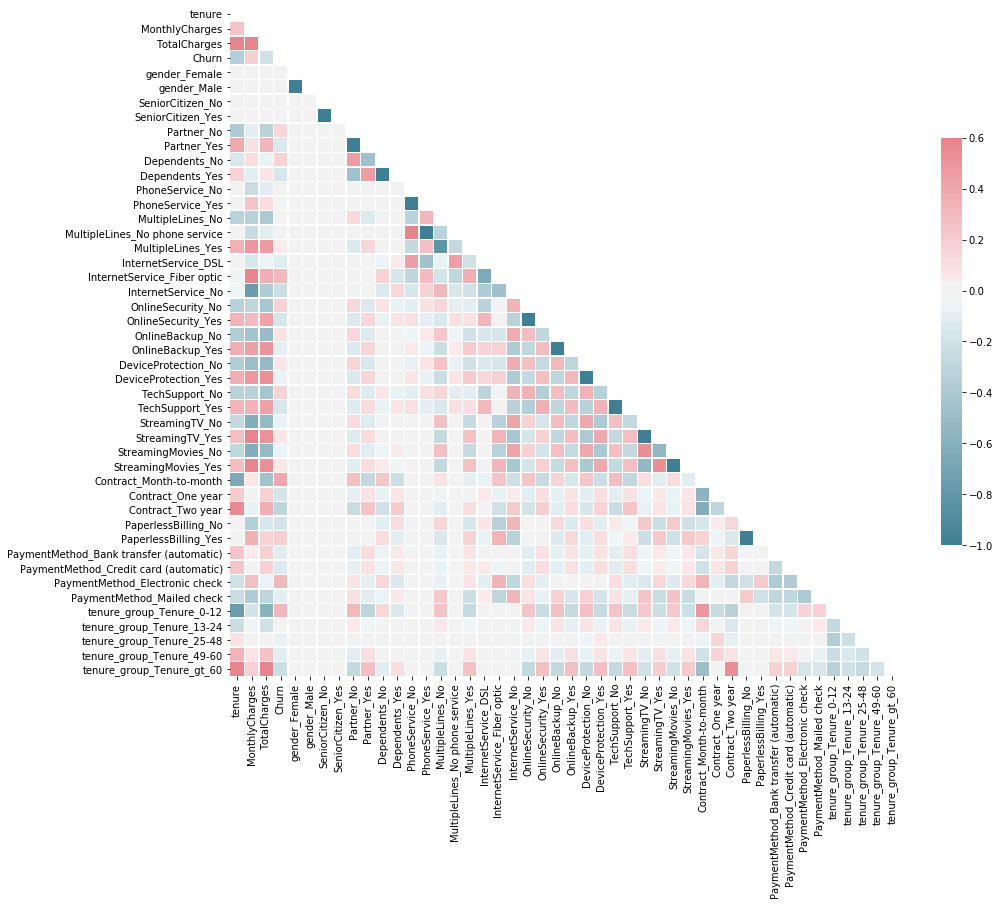

In [49]:
corr_matrix = telcom_2_dummies.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.6, center=0,
            xticklabels=(telcom_2_dummies.nunique().keys().tolist()),
            yticklabels=(telcom_2_dummies.nunique().keys().tolist()),
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [50]:
corr_matrix['Churn'].sort_values(ascending=False)

Churn                                      1.000000
Contract_Month-to-month                    0.404565
tenure_group_Tenure_0-12                   0.319628
InternetService_Fiber optic                0.307463
PaymentMethod_Electronic check             0.301455
MonthlyCharges                             0.192858
PaperlessBilling_Yes                       0.191454
OnlineSecurity_No                          0.171270
TechSupport_No                             0.164716
Dependents_No                              0.163128
Partner_No                                 0.149982
OnlineBackup_No                            0.082307
DeviceProtection_No                        0.066193
StreamingTV_Yes                            0.063254
StreamingMovies_Yes                        0.060860
MultipleLines_Yes                          0.040033
tenure_group_Tenure_13-24                  0.019929
PhoneService_Yes                           0.011691
gender_Female                              0.008545
SeniorCitize

## 5. Data Preparation

Before we apply any transformation to our data, let's split our dataset to avoid data leakage:

In [51]:
y = telcom_2['Churn'].copy()
X = telcom_2.drop(['Churn', 'customerID'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=24)

In [52]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5274, 20)
(5274,)
(1758, 20)
(1758,)


Next, we create a class to select numerical or categorical columns since Scikit-Learn doesn't handle DataFrames.

In [53]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.attribute_names = feature_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Let's now create our numerical and categorical imputers:

In [54]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_att)),
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_att)),
    ('cat_encoder', OneHotEncoder(sparse=False))
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [55]:
X_train_prepared = full_pipeline.fit_transform(X_train)
y_train_prepared = y_train.to_numpy()
print(type(X_train_prepared))
print(type(y_train_prepared))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [56]:
X_test_prepared = full_pipeline.fit_transform(X_test)
y_test_prepared = y_test.to_numpy()
print(type(X_test_prepared))
print(type(y_test_prepared))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## 6. Modelling

### 6.1 Scikit-Learn

In [57]:
def model_scores(model, X_train, y_train):
    pred = model.predict(X_train)
    accuracy = accuracy_score(y_train, pred)
    auc = roc_auc_score(y_train, pred)
    recall = recall_score(y_train, pred)
    precision = precision_score(y_train, pred)
    f1 = f1_score(y_train, pred)
    print(' Accuracy: {:.3f}'.format(accuracy))
    print('      AUC: {:.3f}'.format(auc))
    print('   Recall: {:.3f}'.format(recall))
    print('Precision: {:.3f}'.format(precision))
    print(' F1-Score: {:.3f}'.format(f1))
    print('\n', 'Confusion Matrix:\n', confusion_matrix(y_train, pred))
    return accuracy, auc, recall, precision, f1

In [58]:
def cv_model_scores(model, X_train, y_train):
    
    cv_scores = cross_validate(model,
                               X_train,
                               y_train,
                               scoring=('roc_auc', 'accuracy', 'precision', 'recall'),
                               cv=5,
                               return_train_score=True)
    
    mean_tr_auc = np.mean(cv_scores['train_roc_auc'])
    mean_val_auc = np.mean(cv_scores['test_roc_auc'])
    mean_tr_acc = np.mean(cv_scores['train_accuracy'])
    mean_val_acc = np.mean(cv_scores['test_accuracy'])
    mean_tr_pre = np.mean(cv_scores['train_precision'])
    mean_val_pre = np.mean(cv_scores['test_precision'])
    mean_tr_rec = np.mean(cv_scores['train_recall'])
    mean_val_rec = np.mean(cv_scores['test_recall'])
    
    print('      Avg CV AUC: %.3f' % mean_val_auc)
    print('      Avg CV Acc: %.3f' % mean_val_acc)
    print('Avg CV Precision: %.3f' % mean_val_pre)
    print('   Avg CV Recall: %.3f' % mean_val_rec)
    
    return mean_val_auc, mean_val_acc, mean_val_pre, mean_val_rec

**Baseline Model: Naive Bayes**

In [59]:
nbm = GaussianNB()
nbm.fit(X_train_prepared, y_train_prepared)

GaussianNB(priors=None, var_smoothing=1e-09)

In [60]:
nbm_tr_auc, nbm_tr_acc, nbm_tr_pre, nbm_tr_rec = cv_model_scores(nbm, 
                                                                 X_train_prepared, 
                                                                 y_train_prepared)

      Avg CV AUC: 0.831
      Avg CV Acc: 0.747
Avg CV Precision: 0.517
   Avg CV Recall: 0.780


In [61]:
nbm_te_auc, nbm_te_acc, nbm_te_pre, nbm_te_rec = cv_model_scores(nbm, 
                                                                 X_test_prepared, 
                                                                 y_test_prepared)

      Avg CV AUC: 0.824
      Avg CV Acc: 0.743
Avg CV Precision: 0.510
   Avg CV Recall: 0.789


**Logistic Regression**

In [62]:
lgm = LogisticRegression(max_iter=1000)
lgm.fit(X_train_prepared, y_train_prepared)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [63]:
lgm_tr_auc, lgm_tr_acc, lgm_tr_pre, lgm_tr_rec = cv_model_scores(lgm, X_train_prepared, y_train_prepared)

      Avg CV AUC: 0.846
      Avg CV Acc: 0.804
Avg CV Precision: 0.668
   Avg CV Recall: 0.527


In [64]:
lgm_te_auc, lgm_te_acc, lgm_te_pre, lgm_te_rec = cv_model_scores(lgm, X_test_prepared, y_test_prepared)

      Avg CV AUC: 0.836
      Avg CV Acc: 0.796
Avg CV Precision: 0.654
   Avg CV Recall: 0.515


**Support Vector Machine**

Support Vector Machine algorithms are very well suited for classification of complex small or medium sized datasets, which is our case. So, we will give it a go.

In [69]:
svm = SVC(kernel='linear',
          C=1)
svm.fit(X_train_prepared, y_train_prepared)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [70]:
svm_tr_auc, svm_tr_acc, svm_tr_pre, svm_tr_rec = cv_model_scores(svm, X_train_prepared, y_train_prepared)

      Avg CV AUC: 0.830
      Avg CV Acc: 0.795
Avg CV Precision: 0.660
   Avg CV Recall: 0.482


In [71]:
svm_te_auc, svm_te_acc, svm_te_pre, svm_te_rec = cv_model_scores(svm, X_test_prepared, y_test_prepared)

      Avg CV AUC: 0.817
      Avg CV Acc: 0.795
Avg CV Precision: 0.666
   Avg CV Recall: 0.459


**Random Forest Classifier**

We will train our Random Forest Classifier directly with a Random Grid Search aiming at improving results in the first run. So let's first create the search space:

In [65]:
n_estimators = [int (x) for x in np.linspace(start=100, stop=1000, num=10)]
max_features = ['auto', 'log2']
bootstrap = [True, False]

# Creating the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'bootstrap': bootstrap}

# Random Grid Search
rfm = RandomForestClassifier()
rf_rgs = RandomizedSearchCV(estimator=rfm,
                            param_distributions=random_grid,
                            n_iter = 10*2*2, #total param combinations
                            cv = 5,
                            random_state=24,
                            scoring='accuracy',
                            n_jobs=-1)

rf_rgs.fit(X_train_prepared, y_train_prepared)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [66]:
rf_rgs.best_params_

{'n_estimators': 400, 'max_features': 'auto', 'bootstrap': True}

In [67]:
best_rfm = rf_rgs.best_estimator_
rfm_tr_auc, rfm_tr_acc, rfm_tr_pre, rfm_tr_rec = cv_model_scores(best_rfm, X_train_prepared, y_train_prepared)

      Avg CV AUC: 0.821
      Avg CV Acc: 0.781
Avg CV Precision: 0.617
   Avg CV Recall: 0.469


In [68]:
rfm_te_auc, rfm_te_acc, rfm_te_pre, rfm_te_rec = cv_model_scores(best_rfm, X_test_prepared, y_test_prepared)

      Avg CV AUC: 0.822
      Avg CV Acc: 0.796
Avg CV Precision: 0.652
   Avg CV Recall: 0.506


### 6.2 CatBoost

In [72]:
cbm = CatBoostClassifier(iterations=500,
                         depth=10,
                         learning_rate=0.01,
                         loss_function='Logloss',
                         eval_metric='Accuracy',
                         custom_metric=['Logloss', 'AUC:hints=skip_train~false'],
                         random_seed=24,
                         verbose=True)

In [73]:
cbm.fit(X_train,
        y_train,
        cat_features=cat_att,
        eval_set=(X_test, y_test))

0:	learn: 0.7883959	test: 0.7855518	best: 0.7855518 (0)	total: 138ms	remaining: 1m 8s
1:	learn: 0.7861206	test: 0.7889647	best: 0.7889647 (1)	total: 161ms	remaining: 40.1s
2:	learn: 0.7914297	test: 0.7997725	best: 0.7997725 (2)	total: 176ms	remaining: 29.1s
3:	learn: 0.7956011	test: 0.8031854	best: 0.8031854 (3)	total: 248ms	remaining: 30.7s
4:	learn: 0.7944634	test: 0.8003413	best: 0.8031854 (3)	total: 257ms	remaining: 25.4s
5:	learn: 0.7944634	test: 0.8003413	best: 0.8031854 (3)	total: 294ms	remaining: 24.2s
6:	learn: 0.7923777	test: 0.7997725	best: 0.8031854 (3)	total: 304ms	remaining: 21.4s
7:	learn: 0.7916193	test: 0.8003413	best: 0.8031854 (3)	total: 329ms	remaining: 20.2s
8:	learn: 0.7952218	test: 0.8043231	best: 0.8043231 (8)	total: 382ms	remaining: 20.8s
9:	learn: 0.7925673	test: 0.8026166	best: 0.8043231 (8)	total: 405ms	remaining: 19.8s
10:	learn: 0.7984452	test: 0.7997725	best: 0.8043231 (8)	total: 469ms	remaining: 20.8s
11:	learn: 0.7965491	test: 0.7997725	best: 0.8043231 

98:	learn: 0.8122867	test: 0.8083049	best: 0.8088737 (79)	total: 4.56s	remaining: 18.5s
99:	learn: 0.8122867	test: 0.8083049	best: 0.8088737 (79)	total: 4.57s	remaining: 18.3s
100:	learn: 0.8122867	test: 0.8060296	best: 0.8088737 (79)	total: 4.62s	remaining: 18.3s
101:	learn: 0.8124763	test: 0.8065984	best: 0.8088737 (79)	total: 4.66s	remaining: 18.2s
102:	learn: 0.8130451	test: 0.8054608	best: 0.8088737 (79)	total: 4.69s	remaining: 18.1s
103:	learn: 0.8128555	test: 0.8054608	best: 0.8088737 (79)	total: 4.69s	remaining: 17.9s
104:	learn: 0.8130451	test: 0.8060296	best: 0.8088737 (79)	total: 4.74s	remaining: 17.8s
105:	learn: 0.8126659	test: 0.8071672	best: 0.8088737 (79)	total: 4.8s	remaining: 17.8s
106:	learn: 0.8122867	test: 0.8077361	best: 0.8088737 (79)	total: 4.86s	remaining: 17.9s
107:	learn: 0.8122867	test: 0.8071672	best: 0.8088737 (79)	total: 4.92s	remaining: 17.9s
108:	learn: 0.8122867	test: 0.8077361	best: 0.8088737 (79)	total: 4.98s	remaining: 17.9s
109:	learn: 0.8124763	te

194:	learn: 0.8229048	test: 0.8094425	best: 0.8100114 (188)	total: 9.68s	remaining: 15.1s
195:	learn: 0.8229048	test: 0.8100114	best: 0.8100114 (188)	total: 9.73s	remaining: 15.1s
196:	learn: 0.8229048	test: 0.8100114	best: 0.8100114 (188)	total: 9.75s	remaining: 15s
197:	learn: 0.8230944	test: 0.8105802	best: 0.8105802 (197)	total: 9.79s	remaining: 14.9s
198:	learn: 0.8232840	test: 0.8100114	best: 0.8105802 (197)	total: 9.87s	remaining: 14.9s
199:	learn: 0.8234736	test: 0.8094425	best: 0.8105802 (197)	total: 9.95s	remaining: 14.9s
200:	learn: 0.8236633	test: 0.8083049	best: 0.8105802 (197)	total: 10s	remaining: 14.9s
201:	learn: 0.8234736	test: 0.8088737	best: 0.8105802 (197)	total: 10.1s	remaining: 14.8s
202:	learn: 0.8236633	test: 0.8088737	best: 0.8105802 (197)	total: 10.1s	remaining: 14.8s
203:	learn: 0.8238529	test: 0.8083049	best: 0.8105802 (197)	total: 10.2s	remaining: 14.7s
204:	learn: 0.8246113	test: 0.8077361	best: 0.8105802 (197)	total: 10.2s	remaining: 14.7s
205:	learn: 0.

291:	learn: 0.8323853	test: 0.8100114	best: 0.8117179 (267)	total: 14.6s	remaining: 10.4s
292:	learn: 0.8327645	test: 0.8100114	best: 0.8117179 (267)	total: 14.6s	remaining: 10.3s
293:	learn: 0.8327645	test: 0.8100114	best: 0.8117179 (267)	total: 14.6s	remaining: 10.3s
294:	learn: 0.8331437	test: 0.8100114	best: 0.8117179 (267)	total: 14.7s	remaining: 10.2s
295:	learn: 0.8340918	test: 0.8100114	best: 0.8117179 (267)	total: 14.8s	remaining: 10.2s
296:	learn: 0.8339022	test: 0.8105802	best: 0.8117179 (267)	total: 14.8s	remaining: 10.1s
297:	learn: 0.8342814	test: 0.8105802	best: 0.8117179 (267)	total: 14.8s	remaining: 10.1s
298:	learn: 0.8342814	test: 0.8105802	best: 0.8117179 (267)	total: 14.9s	remaining: 9.98s
299:	learn: 0.8342814	test: 0.8105802	best: 0.8117179 (267)	total: 14.9s	remaining: 9.9s
300:	learn: 0.8342814	test: 0.8105802	best: 0.8117179 (267)	total: 14.9s	remaining: 9.82s
301:	learn: 0.8340918	test: 0.8105802	best: 0.8117179 (267)	total: 14.9s	remaining: 9.74s
302:	learn:

387:	learn: 0.8428138	test: 0.8094425	best: 0.8117179 (267)	total: 18.5s	remaining: 5.35s
388:	learn: 0.8430034	test: 0.8094425	best: 0.8117179 (267)	total: 18.6s	remaining: 5.3s
389:	learn: 0.8430034	test: 0.8100114	best: 0.8117179 (267)	total: 18.6s	remaining: 5.24s
390:	learn: 0.8430034	test: 0.8094425	best: 0.8117179 (267)	total: 18.6s	remaining: 5.2s
391:	learn: 0.8431930	test: 0.8094425	best: 0.8117179 (267)	total: 18.7s	remaining: 5.14s
392:	learn: 0.8428138	test: 0.8094425	best: 0.8117179 (267)	total: 18.7s	remaining: 5.1s
393:	learn: 0.8428138	test: 0.8100114	best: 0.8117179 (267)	total: 18.8s	remaining: 5.05s
394:	learn: 0.8431930	test: 0.8100114	best: 0.8117179 (267)	total: 18.8s	remaining: 5.01s
395:	learn: 0.8431930	test: 0.8105802	best: 0.8117179 (267)	total: 18.9s	remaining: 4.96s
396:	learn: 0.8431930	test: 0.8105802	best: 0.8117179 (267)	total: 19s	remaining: 4.92s
397:	learn: 0.8430034	test: 0.8105802	best: 0.8117179 (267)	total: 19s	remaining: 4.88s
398:	learn: 0.842

479:	learn: 0.8492605	test: 0.8088737	best: 0.8117179 (267)	total: 22.9s	remaining: 955ms
480:	learn: 0.8492605	test: 0.8088737	best: 0.8117179 (267)	total: 22.9s	remaining: 906ms
481:	learn: 0.8494501	test: 0.8088737	best: 0.8117179 (267)	total: 22.9s	remaining: 857ms
482:	learn: 0.8498294	test: 0.8100114	best: 0.8117179 (267)	total: 23s	remaining: 810ms
483:	learn: 0.8498294	test: 0.8100114	best: 0.8117179 (267)	total: 23.1s	remaining: 763ms
484:	learn: 0.8498294	test: 0.8094425	best: 0.8117179 (267)	total: 23.1s	remaining: 715ms
485:	learn: 0.8496397	test: 0.8088737	best: 0.8117179 (267)	total: 23.2s	remaining: 669ms
486:	learn: 0.8492605	test: 0.8088737	best: 0.8117179 (267)	total: 23.3s	remaining: 622ms
487:	learn: 0.8496397	test: 0.8088737	best: 0.8117179 (267)	total: 23.4s	remaining: 575ms
488:	learn: 0.8500190	test: 0.8088737	best: 0.8117179 (267)	total: 23.5s	remaining: 528ms
489:	learn: 0.8502086	test: 0.8094425	best: 0.8117179 (267)	total: 23.6s	remaining: 481ms
490:	learn: 

In [74]:
cbm.get_best_score()

{'learn': {'Accuracy': 0.8505877891543421,
  'Logloss': 0.3300755673837881,
  'AUC': 0.9205301010219934},
 'validation': {'Accuracy': 0.8117178612059158,
  'Logloss': 0.41188354709963904,
  'AUC': 0.8490105193732346}}

In [75]:
cbm_accuracy_train = cbm.score(X_train, y_train)
cbm_accuracy_test = cbm.score(X_test, y_test)
print('Train Acc: %.3f' % cbm_accuracy_train)
print('Test Acc: %.3f' % cbm_accuracy_test)

Train Acc: 0.819
Test Acc: 0.812


**Hyperparamter Optimization**

We will now implement a function optimizer using Hyperopt aiming at identifying the hyperparamters that yield the lowest **Logloss** and highest **Accuracy**:

The template of the optimization function used below was obtained in the following link:

https://colab.research.google.com/drive/1Lte4Pb4lw_w7OGp2wqwS5a50ZgBIcW6j#scrollTo=qZJ28r0Bj5fO

In [76]:
D_train = pool(X_train, y_train, cat_features=cat_att)
D_test = pool(X_test, y_test, cat_features=cat_att)

In [77]:
# number of random sampled hyperparameters
N_HYPEROPT_PROBES = 15

# the sampling aplgorithm 
HYPEROPT_ALGO = tpe.suggest 

def get_catboost_params(space):
    params = dict()
    params['learning_rate'] = space['learning_rate']
    params['depth'] = int(space['depth'])
    params['l2_leaf_reg'] = space['l2_leaf_reg']
    params['one_hot_max_size'] = space['one_hot_max_size']
    return params

# ---------------------------------------------------------------------

obj_call_count = 0
cur_best_loss = np.inf
log_writer = open( 'catboost-hyperopt-log.txt', 'w' )


def objective(space):
    global obj_call_count, cur_best_loss

    obj_call_count += 1

    print('\nCatBoost objective call #{} cur_best_loss={:7.5f}'.format(obj_call_count,cur_best_loss) )

    params = get_catboost_params(space)
  
    model = CatBoostClassifier(iterations=500, 
                               learning_rate=params['learning_rate'], 
                               depth =int(params['depth']), 
                               eval_metric = "Accuracy",
                               l2_leaf_reg=params['l2_leaf_reg'],
                               bagging_temperature=1,
                               one_hot_max_size=params['one_hot_max_size'],
                               use_best_model=True)

    model.fit(D_train, eval_set=D_test, silent=True)
    val_loss = model.best_score_['validation']['Logloss']
    
    if val_loss<cur_best_loss:
      cur_best_loss = val_loss

    return{'loss':cur_best_loss, 'status': STATUS_OK}


# --------------------------------------------------------------------------------

space ={
        'depth': hp.quniform("depth", 4, 12, 1),
        'learning_rate': hp.loguniform('learning_rate', -3.0, -0.7),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
        'one_hot_max_size': hp.quniform("one_hot_max_size", 0, 15, 1)
       }


trials = Trials()
best = hyperopt.fmin(fn=objective,
                     space=space,
                     algo=HYPEROPT_ALGO,
                     max_evals=N_HYPEROPT_PROBES,
                     trials=trials)

print('-'*50)
print('The best params:')
print( best )
print('\n\n')

                                                      
CatBoost objective call #1 cur_best_loss=    inf
                                                                                
CatBoost objective call #2 cur_best_loss=0.40744
                                                                                
CatBoost objective call #3 cur_best_loss=0.40744
                                                                                
CatBoost objective call #4 cur_best_loss=0.40744
                                                                                
CatBoost objective call #5 cur_best_loss=0.40744
                                                                                
CatBoost objective call #6 cur_best_loss=0.40744
                                                                                
CatBoost objective call #7 cur_best_loss=0.40744
                                                                                
CatBoost objective call #8 cur_best

Let's fit now a CatBoost model with the hyperparameters configuration recommended by Hyperopt:

In [78]:
cbm_best = CatBoostClassifier(iterations=500,
                              depth=best['depth'],
                              learning_rate=best['learning_rate'],
                              one_hot_max_size=best['one_hot_max_size'],
                              l2_leaf_reg= best['l2_leaf_reg'],
                              use_best_model=True,
                              loss_function='Logloss',
                              custom_metric=['Logloss', 'AUC:hints=skip_train~false'],
                              eval_metric='Accuracy',
                              random_seed=24,                              
                              verbose=True)

In [79]:
cbm_best.fit(X_train,
             y_train,
             cat_features=cat_att,
             eval_set=D_test)

0:	learn: 0.7385286	test: 0.7303754	best: 0.7303754 (0)	total: 23.3ms	remaining: 11.6s
1:	learn: 0.7887751	test: 0.7997725	best: 0.7997725 (1)	total: 59.5ms	remaining: 14.8s
2:	learn: 0.7912400	test: 0.7992036	best: 0.7997725 (1)	total: 85ms	remaining: 14.1s
3:	learn: 0.7910504	test: 0.8003413	best: 0.8003413 (3)	total: 124ms	remaining: 15.4s
4:	learn: 0.7912400	test: 0.8043231	best: 0.8043231 (4)	total: 165ms	remaining: 16.3s
5:	learn: 0.7899128	test: 0.8065984	best: 0.8065984 (5)	total: 206ms	remaining: 17s
6:	learn: 0.7933257	test: 0.8088737	best: 0.8088737 (6)	total: 245ms	remaining: 17.3s
7:	learn: 0.7944634	test: 0.8071672	best: 0.8088737 (6)	total: 276ms	remaining: 17s
8:	learn: 0.7931361	test: 0.8083049	best: 0.8088737 (6)	total: 313ms	remaining: 17.1s
9:	learn: 0.7959803	test: 0.8094425	best: 0.8094425 (9)	total: 358ms	remaining: 17.5s
10:	learn: 0.8001517	test: 0.8077361	best: 0.8094425 (9)	total: 397ms	remaining: 17.6s
11:	learn: 0.8009101	test: 0.8105802	best: 0.8105802 (11

95:	learn: 0.8202503	test: 0.8134243	best: 0.8156997 (39)	total: 2.86s	remaining: 12s
96:	learn: 0.8206295	test: 0.8134243	best: 0.8156997 (39)	total: 2.89s	remaining: 12s
97:	learn: 0.8206295	test: 0.8134243	best: 0.8156997 (39)	total: 2.91s	remaining: 11.9s
98:	learn: 0.8213879	test: 0.8139932	best: 0.8156997 (39)	total: 2.94s	remaining: 11.9s
99:	learn: 0.8213879	test: 0.8128555	best: 0.8156997 (39)	total: 2.96s	remaining: 11.8s
100:	learn: 0.8211983	test: 0.8139932	best: 0.8156997 (39)	total: 3s	remaining: 11.8s
101:	learn: 0.8219568	test: 0.8139932	best: 0.8156997 (39)	total: 3.04s	remaining: 11.9s
102:	learn: 0.8219568	test: 0.8139932	best: 0.8156997 (39)	total: 3.07s	remaining: 11.8s
103:	learn: 0.8215776	test: 0.8134243	best: 0.8156997 (39)	total: 3.11s	remaining: 11.9s
104:	learn: 0.8215776	test: 0.8134243	best: 0.8156997 (39)	total: 3.14s	remaining: 11.8s
105:	learn: 0.8215776	test: 0.8139932	best: 0.8156997 (39)	total: 3.17s	remaining: 11.8s
106:	learn: 0.8219568	test: 0.812

188:	learn: 0.8359879	test: 0.8151308	best: 0.8174061 (168)	total: 5.4s	remaining: 8.88s
189:	learn: 0.8361775	test: 0.8151308	best: 0.8174061 (168)	total: 5.43s	remaining: 8.86s
190:	learn: 0.8361775	test: 0.8151308	best: 0.8174061 (168)	total: 5.46s	remaining: 8.83s
191:	learn: 0.8365567	test: 0.8151308	best: 0.8174061 (168)	total: 5.49s	remaining: 8.8s
192:	learn: 0.8361775	test: 0.8151308	best: 0.8174061 (168)	total: 5.5s	remaining: 8.76s
193:	learn: 0.8363671	test: 0.8145620	best: 0.8174061 (168)	total: 5.53s	remaining: 8.73s
194:	learn: 0.8369359	test: 0.8145620	best: 0.8174061 (168)	total: 5.57s	remaining: 8.71s
195:	learn: 0.8373151	test: 0.8145620	best: 0.8174061 (168)	total: 5.6s	remaining: 8.69s
196:	learn: 0.8369359	test: 0.8145620	best: 0.8174061 (168)	total: 5.61s	remaining: 8.63s
197:	learn: 0.8369359	test: 0.8151308	best: 0.8174061 (168)	total: 5.63s	remaining: 8.59s
198:	learn: 0.8367463	test: 0.8145620	best: 0.8174061 (168)	total: 5.66s	remaining: 8.56s
199:	learn: 0.

283:	learn: 0.8505878	test: 0.8139932	best: 0.8174061 (168)	total: 7.77s	remaining: 5.91s
284:	learn: 0.8511566	test: 0.8134243	best: 0.8174061 (168)	total: 7.8s	remaining: 5.89s
285:	learn: 0.8511566	test: 0.8134243	best: 0.8174061 (168)	total: 7.82s	remaining: 5.85s
286:	learn: 0.8509670	test: 0.8128555	best: 0.8174061 (168)	total: 7.85s	remaining: 5.83s
287:	learn: 0.8509670	test: 0.8128555	best: 0.8174061 (168)	total: 7.88s	remaining: 5.8s
288:	learn: 0.8509670	test: 0.8128555	best: 0.8174061 (168)	total: 7.91s	remaining: 5.78s
289:	learn: 0.8513462	test: 0.8128555	best: 0.8174061 (168)	total: 7.93s	remaining: 5.74s
290:	learn: 0.8515358	test: 0.8122867	best: 0.8174061 (168)	total: 7.95s	remaining: 5.71s
291:	learn: 0.8521047	test: 0.8128555	best: 0.8174061 (168)	total: 7.98s	remaining: 5.69s
292:	learn: 0.8519151	test: 0.8128555	best: 0.8174061 (168)	total: 8.01s	remaining: 5.66s
293:	learn: 0.8511566	test: 0.8134243	best: 0.8174061 (168)	total: 8.03s	remaining: 5.63s
294:	learn: 

378:	learn: 0.8659462	test: 0.8071672	best: 0.8174061 (168)	total: 10.3s	remaining: 3.29s
379:	learn: 0.8661358	test: 0.8077361	best: 0.8174061 (168)	total: 10.3s	remaining: 3.26s
380:	learn: 0.8663254	test: 0.8083049	best: 0.8174061 (168)	total: 10.4s	remaining: 3.24s
381:	learn: 0.8661358	test: 0.8083049	best: 0.8174061 (168)	total: 10.4s	remaining: 3.21s
382:	learn: 0.8665150	test: 0.8094425	best: 0.8174061 (168)	total: 10.4s	remaining: 3.18s
383:	learn: 0.8663254	test: 0.8088737	best: 0.8174061 (168)	total: 10.4s	remaining: 3.15s
384:	learn: 0.8667046	test: 0.8088737	best: 0.8174061 (168)	total: 10.4s	remaining: 3.12s
385:	learn: 0.8672734	test: 0.8088737	best: 0.8174061 (168)	total: 10.5s	remaining: 3.1s
386:	learn: 0.8670838	test: 0.8077361	best: 0.8174061 (168)	total: 10.5s	remaining: 3.06s
387:	learn: 0.8670838	test: 0.8077361	best: 0.8174061 (168)	total: 10.5s	remaining: 3.04s
388:	learn: 0.8670838	test: 0.8077361	best: 0.8174061 (168)	total: 10.6s	remaining: 3.01s
389:	learn:

473:	learn: 0.8782708	test: 0.8065984	best: 0.8174061 (168)	total: 12.9s	remaining: 707ms
474:	learn: 0.8777019	test: 0.8065984	best: 0.8174061 (168)	total: 12.9s	remaining: 681ms
475:	learn: 0.8777019	test: 0.8065984	best: 0.8174061 (168)	total: 12.9s	remaining: 653ms
476:	learn: 0.8780812	test: 0.8060296	best: 0.8174061 (168)	total: 13s	remaining: 626ms
477:	learn: 0.8782708	test: 0.8060296	best: 0.8174061 (168)	total: 13s	remaining: 598ms
478:	learn: 0.8782708	test: 0.8060296	best: 0.8174061 (168)	total: 13s	remaining: 571ms
479:	learn: 0.8782708	test: 0.8065984	best: 0.8174061 (168)	total: 13.1s	remaining: 544ms
480:	learn: 0.8790292	test: 0.8077361	best: 0.8174061 (168)	total: 13.1s	remaining: 517ms
481:	learn: 0.8790292	test: 0.8077361	best: 0.8174061 (168)	total: 13.1s	remaining: 490ms
482:	learn: 0.8786500	test: 0.8071672	best: 0.8174061 (168)	total: 13.2s	remaining: 463ms
483:	learn: 0.8792188	test: 0.8071672	best: 0.8174061 (168)	total: 13.2s	remaining: 436ms
484:	learn: 0.87

In [80]:
cbm_best.best_score_

{'learn': {'Accuracy': 0.8801668562760713,
  'Logloss': 0.28368547685913187,
  'AUC': 0.9468061211068177},
 'validation': {'Accuracy': 0.8174061433447098,
  'Logloss': 0.4102177766200479,
  'AUC': 0.8499890076213825}}

In [81]:
print('Best Iteration: ', cbm_best.get_best_iteration())
best_scores = cbm_best.get_best_score()
print(best_scores)

Best Iteration:  168
{'learn': {'Accuracy': 0.8801668562760713, 'Logloss': 0.28368547685913187, 'AUC': 0.9468061211068177}, 'validation': {'Accuracy': 0.8174061433447098, 'Logloss': 0.4102177766200479, 'AUC': 0.8499890076213825}}


In [82]:
cbm_best_accuracy_train = cbm_best.score(X_train, y_train)
cbm_best_accuracy_test = cbm_best.score(X_test, y_test)
print('Train Acc: %.3f' % cbm_best_accuracy_train)
print('Test Acc: %.3f' % cbm_best_accuracy_test)

cbm_best_auc_train = best_scores['learn']['AUC']
cbm_best_auc_test = best_scores['validation']['AUC']
print('Train AUC: %.3f' % cbm_best_auc_train)
print('Test AUC: %.3f' % cbm_best_auc_test)

Train Acc: 0.828
Test Acc: 0.817
Train AUC: 0.947
Test AUC: 0.850


In [83]:
best_scores['learn']['AUC']

0.9468061211068177

In [84]:
get_confusion_matrix(cbm_best, D_train)

array([[3564.,  305.],
       [ 601.,  804.]])

In [85]:
get_confusion_matrix(cbm_best, D_test)

array([[1165.,  129.],
       [ 192.,  272.]])

**Feature Importance Analysis**

In [86]:
feature_importance_df = cbm_best.get_feature_importance(prettified=True)
feature_importance_df

,Feature Id,Importances
0,Contract,20.728631
1,tenure,11.625854
2,InternetService,10.890315
3,tenure_group,10.340728
4,MonthlyCharges,7.502085
5,PaymentMethod,6.686654
6,TotalCharges,5.189842
7,PaperlessBilling,4.563436
8,MultipleLines,4.183979
9,TechSupport,3.204279


Text(0.5, 1.0, 'Top 10 CatBoost Features Importance')

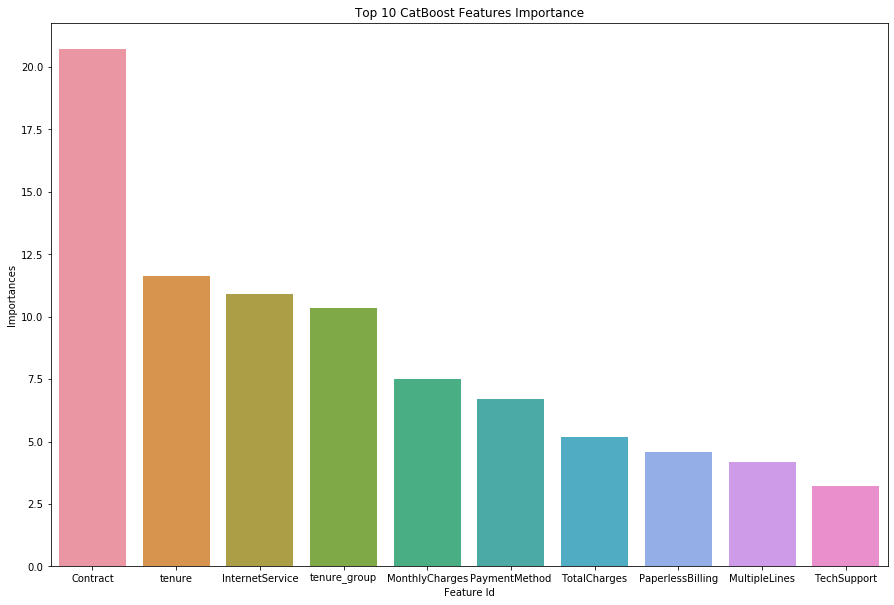

In [87]:
plt.figure(figsize=(15,10))
sns.barplot(x='Feature Id',
            y='Importances',
            data=feature_importance_df[:10])
plt.title('Top 10 CatBoost Features Importance')

### 6.4 XGBoost

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. 

In [88]:
one_hot_cols = pd.get_dummies(X_train).columns.tolist()
X_tr = pd.DataFrame(X_train_prepared, columns=one_hot_cols)
X_te = pd.DataFrame(X_test_prepared, columns=one_hot_cols)

In [89]:
xgb = XGBClassifier(max_depth=5,
                    learning_rate=0.1,
                    objective='binary:logistic',
                    n_jobs=-1)
xgb.fit(X_tr, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [90]:
print('Accuracy of XGB Classifier on training set: {:.3f}'.
      format(xgb.score(X_tr, y_train)))
print('Accuracy of XGB Classifier on test set: {:.3f}'.
      format(xgb.score(X_te, y_test)))

Accuracy of XGB Classifier on training set: 0.855
Accuracy of XGB Classifier on test set: 0.816


In [91]:
print('Cross-Validation Training Set Results:')
cv_model_scores(xgb, X_tr, y_train)
print('\n Cross Validation Test Set Results:')
cv_model_scores(xgb, X_te, y_test)

Cross-Validation Training Set Results:
      Avg CV AUC: 0.836
      Avg CV Acc: 0.794
Avg CV Precision: 0.642
   Avg CV Recall: 0.513

 Cross Validation Test Set Results:
      Avg CV AUC: 0.821
      Avg CV Acc: 0.790
Avg CV Precision: 0.633
   Avg CV Recall: 0.515


(0.8208430213143348, 0.7900997150997151, 0.63252232083473, 0.5151238896680692)

**Hyperparamter Optimization**

We will now implement a function optimizer using Hyperopt aiming at identifying the hyperparamters that yield the lowest **Logloss** and highest **Accuracy**:

In [92]:
# Setting up the space dictionary

space = {'max_depth': hp.quniform('max_depth', 2, 10, 2),
         'nthread': hp.randint('nthread', 10),
         'eta': hp.uniform('eta', 0, 1.0) # learning rate
}

In [93]:
def objective(params):
    params = {'max_depth': int(params['max_depth']),
              'nthread': params['nthread'],
              'eta': params['eta']}
    xgb_clf = XGBClassifier(**params) 
    best_score = cross_val_score(xgb_clf, X_tr, y_train, 
                                 scoring='accuracy', cv=5, n_jobs=-1).mean()
    loss = 1 - best_score
    return loss

In [94]:
# Run the algorithm
best = fmin(fn=objective,
            space=space, 
            max_evals=20, 
            rstate=np.random.RandomState(24), 
            algo=tpe.suggest)
print(best)

100%|██████████| 20/20 [00:57<00:00,  2.86s/trial, best loss: 0.1981447341205248]
{'eta': 0.08441494262485238, 'max_depth': 2.0, 'nthread': 3}


In [95]:
best_xgb = XGBClassifier(eta=best['eta'],
                         max_depth=int(best['max_depth']),
                         nthread=best['nthread'])
best_xgb.fit(X_tr, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.08441494262485238,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.0844149441,
              max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=3, nthread=3,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [96]:
best_xgb_tr_acc = best_xgb.score(X_tr, y_train)
best_xgb_te_acc = best_xgb.score(X_te, y_test)

print('Accuracy of XGB Classifier on training set: {:.3f}'.
      format(best_xgb_tr_acc))
print('Accuracy of XGB Classifier on test set: {:.3f}'.
      format(best_xgb_te_acc))

Accuracy of XGB Classifier on training set: 0.813
Accuracy of XGB Classifier on test set: 0.814


In [97]:
print('Cross-Validation Training Set Results:')
xgb_tr_auc, xgb_tr_acc, xgb_tr_pre, xgb_tr_rec = cv_model_scores(best_xgb, X_tr, y_train)
print('\n Cross Validation Test Set Results:')
xgb_te_auc, xgb_te_acc, xgb_te_pre, xgb_te_rec = cv_model_scores(best_xgb, X_te, y_test)

Cross-Validation Training Set Results:
      Avg CV AUC: 0.847
      Avg CV Acc: 0.802
Avg CV Precision: 0.670
   Avg CV Recall: 0.507

 Cross Validation Test Set Results:
      Avg CV AUC: 0.843
      Avg CV Acc: 0.801
Avg CV Precision: 0.658
   Avg CV Recall: 0.524


Let's now take a look at XGBoost's interpretation of the most important features used in the model.

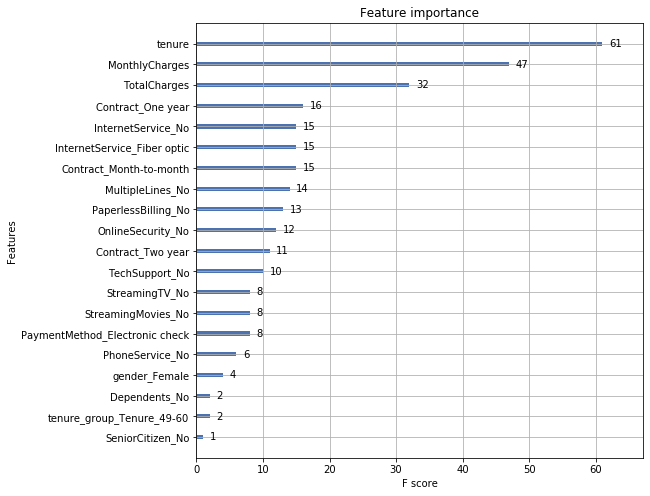

In [98]:
fig, ax = plt.subplots(figsize=(8,8))
plot_importance(best_xgb, ax=ax)

We can see that according to our XGB model, the most important variables to predict churn rates are:
* Tenure
* Monthly Charges
* Total Charges

Let's have a look at the confusion matrix:

[[3530  339]
 [ 645  760]]


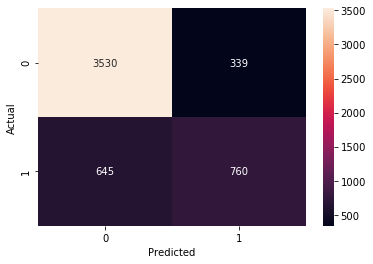

In [130]:
y_pred = best_xgb.predict(X_tr)
conf_mat = confusion_matrix(y_train, y_pred)
print(conf_mat)
confusion_matrix_ = pd.crosstab(y_train, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix_, annot=True, fmt="d")
plt.show()

[[1180  114]
 [ 213  251]]


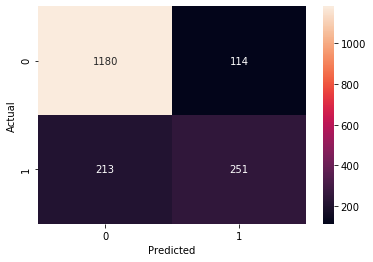

In [131]:
y_pred_te = best_xgb.predict(X_te)
conf_mat_te = confusion_matrix(y_test, y_pred_te)
print(conf_mat_te)
confusion_matrix_te = pd.crosstab(y_test, y_pred_te, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix_te, annot=True, fmt="d")
plt.show()

## 7. Final Results

In [99]:
index_=['Naiva Bayes', 
        'Logistic Regression', 
        'Random Forest (Random Grid Search)',
        'Support Vector Machine',
        'CatBoost (HyperOpt)',
        'XGBoost (HyperOpt)']

all_models = {'Training Accuracy':np.round([nbm_tr_acc,
                                            lgm_tr_acc,
                                            rfm_tr_acc,
                                            svm_tr_acc,
                                            cbm_best_accuracy_train,
                                            best_xgb_tr_acc], 3),
              'Test Accuracy':np.round([nbm_te_acc,
                                        lgm_te_acc,
                                        rfm_te_acc,
                                        svm_te_acc,
                                        cbm_best_accuracy_test,
                                        best_xgb_te_acc],3),
              'Training AUC':np.round([nbm_tr_auc,
                                       lgm_tr_auc,
                                       rfm_tr_acc,
                                       svm_tr_auc,
                                       cbm_best_auc_train,
                                       xgb_tr_auc], 3),
              'Test AUC':np.round([nbm_te_auc,
                                   lgm_te_auc,
                                   rfm_te_auc,
                                   svm_te_auc,
                                   cbm_best_auc_test,
                                   xgb_te_auc],3)
    
}

In [100]:
final_results_df = pd.DataFrame(data=all_models, index=index_)
final_results_df.sort_values(by='Test Accuracy', ascending=False)

,Training Accuracy,Test Accuracy,Training AUC,Test AUC
CatBoost (HyperOpt),0.828,0.817,0.947,0.850
XGBoost (HyperOpt),0.813,0.814,0.847,0.843
Logistic Regression,0.804,0.796,0.846,0.836
Random Forest (Random Grid Search),0.781,0.796,0.781,0.822
Support Vector Machine,0.795,0.795,0.830,0.817
Naiva Bayes,0.747,0.743,0.831,0.824


We can see that in terms of 'Accuracy' both the CatBoost and XGBoost performed well (as expected). However, looking at the AUC figures, we can see that the CatBoost algorithm overfitted quite a lot. Thus, the selected algorithm to predict customers likely to Churn, for this particular work, is the HyperOpt optimized **XGBoost** algorithm.

Finally, the best way to use this model is assigning Churn Probability for each customer and build strategies on top of that. To get the churn probability from our model, the code below can be used.

In [101]:
best_xgb.predict_proba(X_tr)[:,1]

array([0.57711154, 0.27253523, 0.04791311, ..., 0.53535295, 0.6430056 ,
       0.02817983], dtype=float32)